# **Оценка качества и неопределенностей модели линейной регрессии** (по реальным данным климатической модели ИВМ РАН версии INM-CM6P).

*Шаг модели - 1.5 $^{\circ}$ от 90 $^{\circ}$ ю.ш. до 90 $^{\circ}$ с.ш. и 2 $^{\circ}$ от 180 $^{\circ}$ з.д. до 180 $^{\circ}$ в.д.*

In [252]:
# импортируем всех необходимые библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import display, Math
from sklearn.utils import indexable
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_validate, TimeSeriesSplit, ShuffleSplit

### Считываем данные модели INM-CM6P как в задании №3

In [213]:
df = pd.read_csv('SST_1960_2024.csv', parse_dates=['time'])
df['time'] = df['time'].dt.strftime('%Y-%m')
df = df.set_index('time')
df.head()

,lat,lon,SST,T2,PS,PREC
time,,,,,,
1960-01,15.75,-60.0,24.563684,22.784052,1016.594604,57.730061
1960-02,15.75,-60.0,23.691187,22.297662,1017.168457,40.946360
1960-03,15.75,-60.0,23.696558,22.015161,1015.526978,27.165576
1960-04,15.75,-60.0,24.496667,23.617761,1014.915100,21.852676
1960-05,15.75,-60.0,24.893915,24.117120,1015.490417,26.074183


Используются <u>среднемесячные</u> поля - **температура поверхности океана (ТПО), температура воздуха на 2 м (Т2), давление на уровне моря (ДУМ) и атмосферные осадки (АО)** для периода января 1960 г. - декабря 2014 г. для точки с коррдинатами 15.75 $^{\circ}$ с.ш., 60 $^{\circ}$ з.д., расположенной в области распространения ЭНЮК. 

<Axes: ylabel='Frequency'>

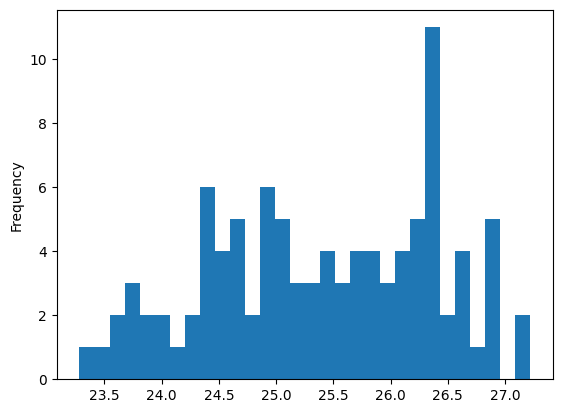

In [214]:
data2stat = df['SST'].dropna().sample(100, random_state=42) # выбираем 100 случайных элементов
data2stat.plot.hist(bins=30) # строим распределение для всей выборки ТПО

Видим, что распределение целевой переменной достаточно далеко от нормального.

### Задействуем уже знакомую модель машинного обучения - линейную регрессию

Вычисляем ее коэффициенты $\theta$

In [215]:
df_Xy = df.copy().drop(columns=['lat', 'lon']).dropna()

y = df_Xy['SST'] # целевая переменная - ТПО
X = df_Xy.drop('SST', axis=1) # признаковое описание - Т2, ДУМ и АО

model = LinearRegression()
model.fit(X, y)
true_theta = model.coef_ # вычисляем коэффициенты линейной регрессии модели

print('Model θ')
for i in range(len(true_theta)):
    display(Math(r'\theta_{%d}: %.3f' % (i, true_theta[i])))

X_array = X.values # преобразуем из pandas в NumPy 
y_array = y.values.reshape(-1, 1) #  преобразуем из pandas в NumPy (двумерный массив)

Model θ


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Максимальна величина первого коэффициента $\theta$, который связан с температурой воздуха на уровне 2 м. Не удивительно, что наибольшее влияние на температуру поверхности океана оказывает именно эта метеовеличина. Второй по значимости и единственный отрицательный коэффициент $\theta$ описывает давление на уровне моря. В предыдущим задании уже была кратко прокоментирована такая связь. Наименьшее влияние, причем положительное, оказывают атмосферные осадки - так, коэффициент модели $\theta$ составляет всего 0.002.

## Применяем метод **bootstrap** для формирования выборок и анализа выборочных средних

*Простейший метод кросс-валидации hold-out уже ранее был применен в задании №3*

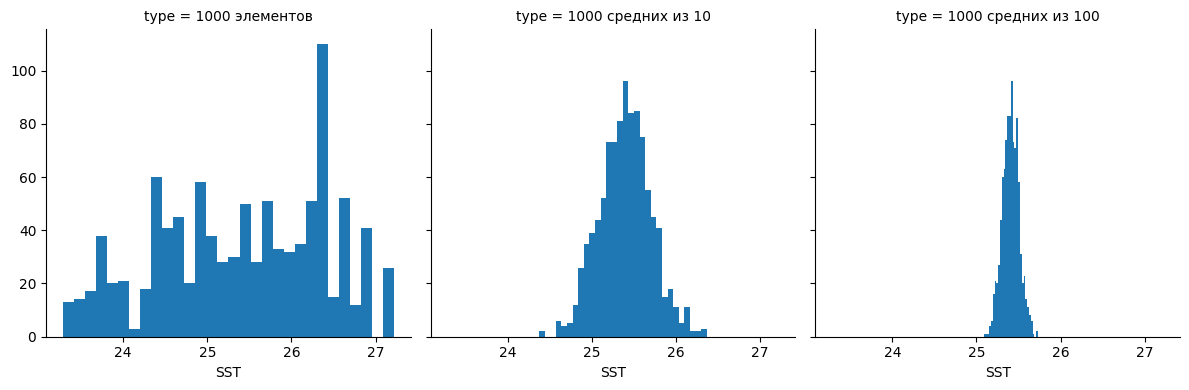

In [216]:
n = 1000 # задаем размер основной bootstrap-выборки

subsample_sizes = [10, 100] # задаем размер подвыборок

sample_data = pd.DataFrame({'SST':data2stat.sample(n, replace=True, random_state=42),
'type':'%d элементов'%n})
results = [sample_data]

for sn in subsample_sizes:
    results.append(pd.DataFrame({'SST':[data2stat.sample(sn, replace=True).mean() for _ in range (n)],
    'type':'%d средних из %d'%(n, sn)}))

results = pd.concat(results)                              

g = sns.FacetGrid(results, col = 'type', height = 4, aspect = 1)
g.map (plt.hist, 'SST', bins=30)

Крайний левый график отражает распределение ТПО в основной  bootstrap-выборке (1000 элементов). Центральный график показывает распределение средних значений в подвыборке длиной 10 элементов, а крайний правый - в подвыборке из 100 элементов. Полученное изображение наглядно демонстрирует Центральную предельную теорему (**ЦПТ**) - при увеличении размера подвыборки распределение средних значений все более стремится к <u>нормальному</u> (уменьшается разброс средних значений - т.е. дисперсия).

### Оценим неопределенность параметров модели линейной регрессии и метрики качества

In [217]:
def sample_bootstrap(X, Y, sample_size, return_OOB_sample):
    sample_indices = np.random.randint(0,X.shape[0], sample_size) # создаем индексы для bootstrap-выборки
    if return_OOB_sample: # функция возвращает bootstrap- и OOB- выборки
        oob_indices = np.array([i for i in np.arange(0, X.shape[0], 1, dtype=int) if i not in sample_indices]) 
         # создаем индексы для OOB-выборки
        return X[sample_indices, :], Y[sample_indices, :], X[oob_indices, :], Y[oob_indices, :]
    else:  # функция возвращает только bootstrap-выборку
        return X[sample_indices, :], Y[sample_indices, :]

In [218]:
B = 1000 # задаем количество bootstrap-выборок
sample_size = 1000 # задаем размер каждой bootstrap-выборки
model_theta = [] # коэффициенты модели тета
model_rmse = [] # метрика качества - СКО
model_r = [] # метрика качества - коэффициент корреляции
model_R2 = [] # метрика качества - коэффициент детерминации

for i in tqdm(range(B), total=B):
    X_train, y_train, X_test, y_test = sample_bootstrap(X_array, y_array, sample_size=sample_size, return_OOB_sample=True)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_test_predicted = model.predict(X_test)
    model_theta.append(np.copy(model.coef_))
    y_test_flat = y_test.flatten()
    y_test_predicted_flat = y_test_predicted.flatten()
    model_rmse.append(np.sqrt(mean_squared_error(y_test_flat, y_test_predicted_flat)))
    model_r.append(np.corrcoef(y_test_flat, y_test_predicted_flat)[0, 1])
    model_R2.append(r2_score(y_test_flat, y_test_predicted_flat))
model_theta = np.array(model_theta).squeeze()
model_rmse = np.array(model_rmse).squeeze()
model_r = np.array(model_r).squeeze()
model_R2 = np.array(model_R2).squeeze()

100%|██████████| 1000/1000 [00:07<00:00, 134.09it/s]


Поскольку используемая в данном исследовании модель относится к классу **линейной регрессии**, в качестве метрик ее качества были выбраны **СКО**, **коэффициенты корреляции** и **детерминации**.

Text(0.5, 1.0, 'Mean quality metrics: RMSE = 0.260 ± 0.013, r = 0.966 ± 0.004, $r^2$ = 0.934 ± 0.000, R2 = 0.932 ± 0.009')

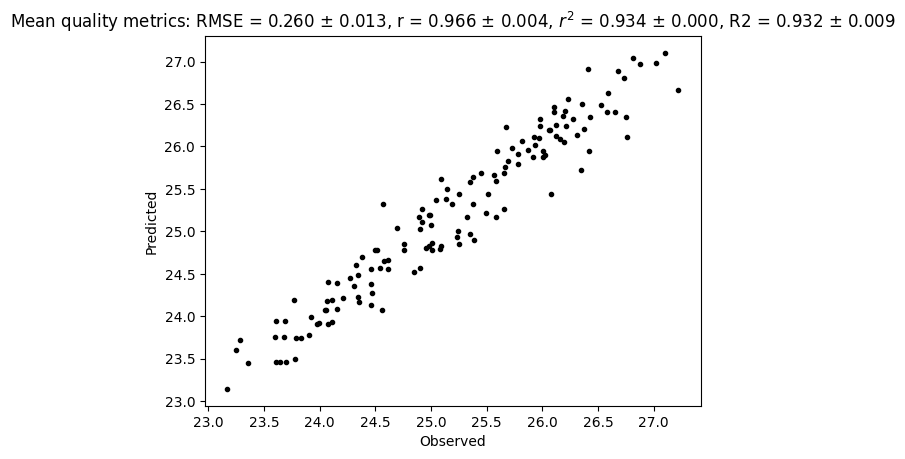

In [219]:
plt.figure()
plt.plot(y_test, y_test_predicted, '.k')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title (f'Mean quality metrics: RMSE = {np.mean(model_rmse):.3f} \u00B1 {np.std(model_rmse):.3f}, ' 
f'r = {np.mean(model_r):.3f} \u00B1 {np.std(model_r):.3f}, ' 
f'$r^2$ = {(np.mean(model_r)**2):.3f} \u00B1 {(np.std(model_r)**2):.3f}, ' 
f'R2 = {np.mean(model_R2):.3f} \u00B1 {np.std(model_R2):.3f}')

На основании полученного графика можно сделать вывод о высоком качестве воспроизведения ТПО - получены большие значения средних коэффициентов корреляции (**высокая** линейная связь между "реальными" и "спрогнозированными" значениями ТПО) и детерминации (интерпретируется почти **вся изменчивость** ТПО), небольшая средняя СКО (**высокая точность** модели). Интересно отметить, что **квадрат коэффициента корреляции** и **коэффициент детерминации** совпадают с точностью до тысячных. Неопределенность метрик качества, выраженная в виде стандартного отклонения $\sigma$, также невелика. Ее величина максимальна для **СКО** - порядок сотых и с точностью до тысячных равна 0 для **квадрата коэффициента корреляции**.

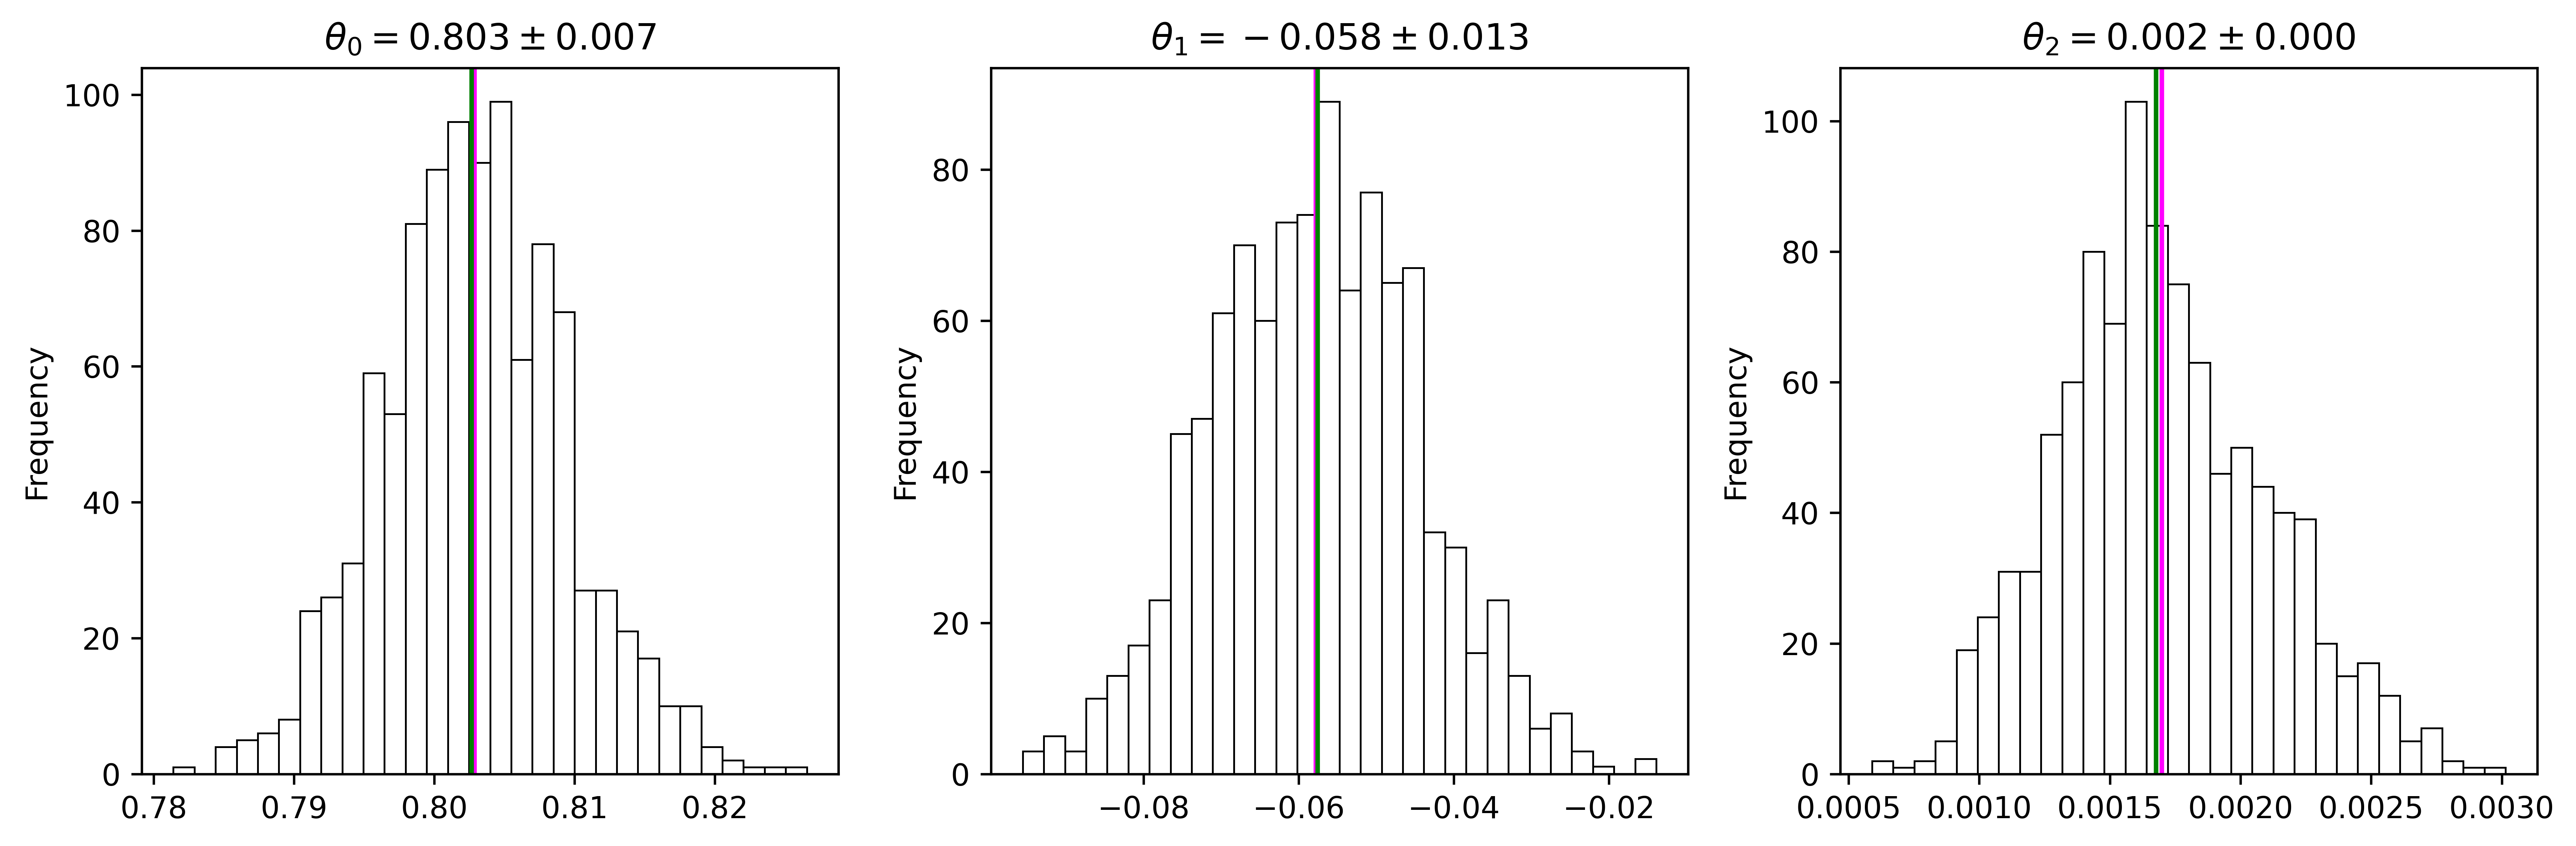

In [220]:
f = plt.figure(figsize=(12,4), dpi=600)
for i in range(model_theta.shape[1]):
    plt.subplot(1, 3, i+1)
    h_counts,h_bins,_ = plt.hist(model_theta[:,i], bins=30, color='white', ec="black", linewidth=0.6)
    mean_theta_i = np.mean(model_theta[:,i]) # рассчитываем среднее значение коэффициента
    std_theta_i = np.std(model_theta[:,i]) # рассчитываем СКО коэффициента
    y_lim = plt.ylim()
    
    plt.vlines(mean_theta_i,  y_lim[0], y_lim[1], color='magenta')
    plt.vlines(true_theta[i], y_lim[0], y_lim[1], color='green')
    plt.ylim(y_lim)
    plt.title(f'$\\theta_{{{i}}} = {mean_theta_i:.3f} \\pm {std_theta_i:.3f}$')
    plt.ylabel('Frequency')
    
_ = plt.tight_layout()

Построенные графики позволяют оценить **устойчивость/неустойчивость оценки коэффициента**. Крайний левый подграфик показывает, что среднее значение I коэффициента (**Т2**) <u>максимально</u> (<u>по модулю</u>), стандартное отклонение крайне невелико - оценка коэффициента **очень надежна**. Линия среднего значения bootstrap-выборки (*розовая*) и исходной выборки (*зеленая*) <u>практически совпадают</u> - значения модели *приближены* к "истинным". II коэффициент (*центральный график*, **ДУМ**) отрицателен, стандартное отклонение достаточно мало - оценка коэффициента **надежна**. Линия среднего значения bootstrap-выборки и оригинальной выборки <u>накладываются друг на друга</u> - *практически полное совпадение* с исходными значениями. III коэффициент (*на крайнем правом графике*, **АО**) вновь положителен, но его значение очень мало, стандартное отклонение равно 0 с точностью до тысячных (*отсутствует разброс*) - данный параметр **влияния почти не оказывает**. Линии среднего значения bootstrap-выборки и оригинальной выборки <u>пересекаются</u> - *значительное согласование* модельных и начальных значений. Итак, модель **устойчива** и полученным bootstrap-оценкам **можно доверять**, причем **наиболее "весомым** является первый коэффициент $\theta$. Полученные коэффициенты $\theta$ с точностью до значений величины неопределенности $\sigma$ (стандартное отклонение) **равны** исходным коэффициентам модели линейной регресии. Малая неопределенность свидетельствует о **надежности** и **стабильности** модели (*т.е. ее качество не зависит от конкретной bootstrap-выборки*).

## **Пункты 1 и 2**. Применяем метод **TimeSeriesSplit**, который учитывает <u>временную</u> структуру и обычно применяется для <u>временных</u> рядов.

*Метод **K-fold** является обобщением простейшего метода **hold-out**, который уже ранее был использован в задании №3. Кроме того, в случае достаточно большого объема данных он является вычислительно затратным, поэтому в данной работе он применяться не будет. Метод **Stratified K-fold** реализуется в задаче классификации, поэтому для данного исследования он не подойдет. Метод **Leave-One-Out** дает достаточно большую дисперсию и подходит лишь для небольших массивов данных, поэтому его мы применять также не будем.*

Обобщая, для кросс-валидации <u>временных</u> рядов наиболее подходящим является именно метод **TimeSeriesSplit**, который позволяет сохранить <u>временную</u> последовательность данных, учитывает их автокорреляцию и предотвращает т.н. **"утечку данных"** из прошлого в будущее и наоборот.

In [222]:
n_splits = 5  # задаем количество фолдов
tscv = TimeSeriesSplit(n_splits=n_splits)

model_theta = [] # коэффициенты модели тета
model_rmse = [] # метрика качества - СКО
model_r = [] # метрика качества - коэффициент корреляции
model_R2 = [] # метрика качества - коэффициент детерминации

# сохраняем последние тестовые данные для графика
last_y_test = None
last_y_test_predicted = None

for train_index, test_index in tqdm(tscv.split(X_array), total=n_splits):
    X_train, X_test = X_array[train_index], X_array[test_index]
    y_train, y_test = y_array[train_index], y_array[test_index]
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_test_predicted = model.predict(X_test)

    y_test_flat = y_test.flatten()
    y_test_predicted_flat = y_test_predicted.flatten()
    
    model_theta.append(np.copy(model.coef_))
    model_rmse.append(np.sqrt(mean_squared_error(y_test_flat, y_test_predicted_flat)))
    model_r.append(np.corrcoef(y_test_flat, y_test_predicted_flat)[0, 1])
    model_R2.append(r2_score(y_test_flat, y_test_predicted_flat))
    
    # сохраняем последний фолд для графика
    last_y_test = y_test
    last_y_test_predicted = y_test_predicted

model_theta = np.array(model_theta).squeeze()
model_rmse = np.array(model_rmse).squeeze()
model_r = np.array(model_r).squeeze()
model_R2 = np.array(model_R2).squeeze()

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 44.36it/s]


In [ ]:
print('Сross_val_score results')
r2_scores = cross_val_score(model, X_array, y_array.ravel(), cv=tscv, scoring='r2')
rmse_scores = cross_val_score(model, X_array, y_array.ravel(), cv=tscv, scoring='neg_root_mean_squared_error')

print ('RMSE cross_val_score mean: ', -rmse_scores.mean()) 
print ('RMSE cross_val_score std: ', rmse_scores.std()) 

print ('R2 cross_val_score mean: ', r2_scores.mean()) 
print ('R2 cross_val_score std: ', r2_scores.std()) 

print('Cross_validate results')

scoring = ['r2', 'neg_root_mean_squared_error']

results = cross_validate(model, X_array, y_array.ravel(), cv=tscv, scoring=scoring, return_train_score=True, return_estimator=True)

print('RMSE cross_validate mean (train): ', -results['train_neg_root_mean_squared_error'].mean()) 
print('RMSE cross_validate std (train): ', results['train_neg_root_mean_squared_error'].std()) 
print('RMSE cross_validate mean (test): ', -results['test_neg_root_mean_squared_error'].mean()) 
print('RMSE cross_validate std (test): ', results['test_neg_root_mean_squared_error'].std()) 

print('R2 cross_validate mean (train): ', results['train_r2'].mean())
print('R2 cross_validate std (train): ', results['train_r2'].std()) 
print('R2 cross_validate mean (test): ', results['test_r2'].mean())
print('R2 cross_validate std (test): ', results['test_r2'].std()) 

Сross_val_score results
RMSE cross_val_score mean:  0.26466468018387124
RMSE cross_val_score std:  0.004199448624148393
R2 cross_val_score mean:  0.9277950876669087
R2 cross_val_score std:  0.004464303482057007
Cross_validate results
RMSE cross_validate mean (train):  0.25483816565885015
RMSE cross_validate std (train):  0.001383087856149059
RMSE cross_validate mean (test):  0.26466468018387124
RMSE cross_validate std (test):  0.004199448624148393
R2 cross_validate mean (train):  0.931853714070552
R2 cross_validate std (train):  0.0011283392649815015
R2 cross_validate mean (test):  0.9277950876669087
R2 cross_validate std (test):  0.004464303482057007


Были применены 2 подхода кросс-валидации - **Сross_val_score** и **Cross_validate**. В качестве метрик были выбраны уже упомянутые ранее **СКО** и **коэффициент детерминации**, которые характеризуют 1) средний разброс между моделируемыми и фактическими значениями целевой переменной и 2) описываемую моделью долю дисперсии целевой переменной соответственно. Методом **Сross_val_score** были подсчитаны средние значения этих параметров и их неопределенность (мерой выступает стандартное отклонение $\sigma$) для всего массива данных. Значение **средней СКО** *мало* - она *не превышает* 2.7, тогда как **средний коэффициент детерминации** почти *достигает* 0.93. Интересно, что неопределенность этих 2 величин совпадает с точностью до тысячных. Метод **Cross_validate** позволяет посчитать соответствующие характеристики отдельно для тренировочной и тестовой выборок. **Средняя СКО** для тестовой выборки *превышает* эту величину для тренировочной на 0.01. **Неопределенность СКО** тестовой выборки *превышает* **неопределенность СКО** тренировочной на 0.003. Значение **среднего коэффициента детерминации** для тренировочной выборки превышает его значение для тестовой выборки на 0.004, тогда как его **неопределенность** для тестовой выборки превышает эту же величину для тренировочной на 0.003.

Text(0.5, 1.0, 'Mean quality metrics for last test fold: RMSE = 0.265 ± 0.004, r = 0.966 ± 0.003, $r^2$ = 0.933 ± 0.000, R2 = 0.928 ± 0.004')

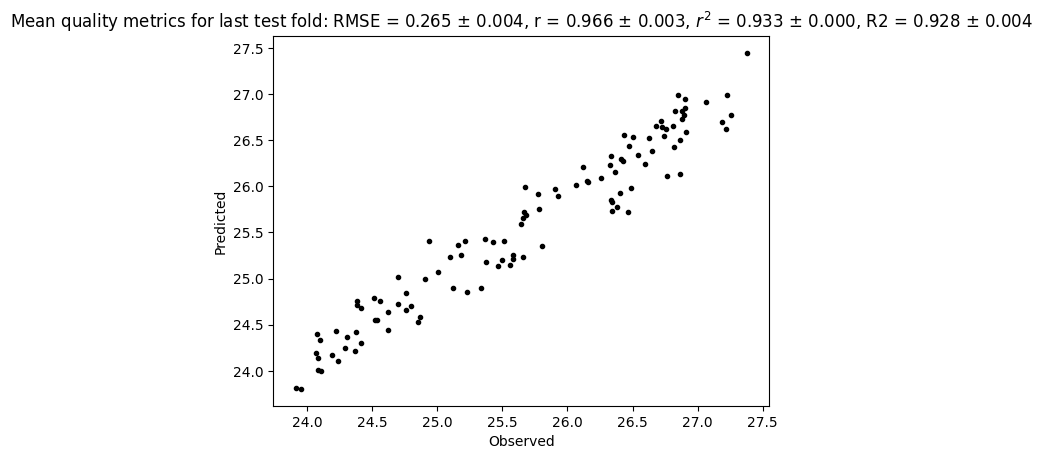

In [227]:
plt.figure()
plt.plot(last_y_test, last_y_test_predicted, '.k')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title(f'Mean quality metrics for last test fold: RMSE = {np.mean(model_rmse):.3f} \u00B1 {np.std(model_rmse):.3f}, ' 
          f'r = {np.mean(model_r):.3f} \u00B1 {np.std(model_r):.3f}, ' 
          f'$r^2$ = {(np.mean(model_r)**2):.3f} \u00B1 {(np.std(model_r)**2):.3f}, ' 
          f'R2 = {np.mean(model_R2):.3f} \u00B1 {np.std(model_R2):.3f}')

Представленная диаграмма рассеяния позволяет заключить, что  метод **TimeSeriesSplit** позволяет воспроизводить значения ТПО по таким предикторам, как температура воздуха на 2, ДУМ и АО с достаточно большой степенью **надежности**. Получены большие значения средних коэффициентов корреляции (**высокая** линейная связь между "фактической" и "модельной" ТПО) и детерминации (объясняется **большая часть изменчивости** ТПО), достаточно небольшая средняя СКО (**высокая точность** модели). Неопределенность вышеописанных метрик качества, выраженная в виде стандартного отклонения $\sigma$, также достаточно невелика. Ее величина максимальна для **СКО** и **коэффициента детерминации** и с точностью до тысячных равна 0 для **квадрата коэффициента корреляции**, как и для метода **Bootstrap**. Сравнивая полученные значения метрик качества и их неопределенность, хотелось бы отметить, что сами средние показатели для метода **Bootstrap** превышают аналогичные величины для метода **TimeSeriesSplit**, тогда как неопределенность несколько (для СКО - на 1 порядок) меньше для последнего. Наибольшая разница в средних значениях - для СКО (на 0.005) и аналогичная величина разницы неопределенности - для коэффициента детерминации. Исключение составляет лишь коэффициент корреляции, среднее значение которого в обоих методах очень высоко - 0.966.

In [228]:
print('Model θ')
for i in range(model_theta.shape[1]):
    mean_val = np.mean(model_theta[:, i])
    std_val = np.std(model_theta[:, i])
    display(Math(fr'\theta_{{{i}}} = {mean_val:.3f} \pm {std_val:.3f}'))

Model θ


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

 Как и следовало ожидать, среднее значение I коэффициента (**Т2**) <u>максимально</u> (<u>по модулю</u> и положительно), стандартное отклонение достаточно невелико (но *максимально* по сравнению с другими коэффициентами $\theta$) - оценка коэффициента **надежна**. II коэффициент (**ДУМ**) отрицателен, стандартное отклонение невелико - как и для Т2, оценка данного коэффициента достаточно **надежна**. III коэффициент (**АО**) положителен, как и для температуры воздуха, но его значение очень мало и всего лишь на 0.002 превышает собственное стандартное отклонение - данный параметр **влияния почти не оказывает**, но его оценку нельзя считать абсолютно **надежной**. Как и в случае метода **Bootstrap**, **наиболее значимым** является I коэффициент $\theta$. Но в отличие от средних значений и неопределенности метрик качества модели, эти характеристики для параметров модели более значительно отличаются от полученных методом **Bootstrap** и, соответственно, исходной модели линейной регрессии. Так, максимальное отличие, как ни странно, отмечается для I коэффициента, "отвечающего" за температуру на 2 м - величина разницы между средними значениями коэффициента составляет 0.035, а разница в неопределенности - 0.009. Минимальные (и совпадающие по величине) отличия для среднего значения и его неопределенности отмечаются для III коэффициента (атмосферные осадки) - всего 0.001.

### **Пункт 4_1**. Проанализируем статистическую значимость **масштабирования** исходных данных на качество модели

*Используем тот же метод, что и в задании №3 - StandardScaler*

In [ ]:
n_splits = 5  # задаем количество фолдов
tscv = TimeSeriesSplit(n_splits=n_splits)

model_theta = [] # коэффициенты модели тета

scaler = StandardScaler()

for train_index, test_index in tqdm(tscv.split(X_array), total=n_splits):
    X_train, X_test = X_array[train_index], X_array[test_index]
    y_train, y_test = y_array[train_index], y_array[test_index]

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = model
    model.fit(X_train, y_train)
    y_test_predicted = model.predict(X_test)

    y_test_flat = y_test.flatten()
    y_test_predicted_flat = y_test_predicted.flatten()
    
    model_theta.append(np.copy(model.coef_))

model_theta = np.array(model_theta).squeeze()

print('Model θ with scaling')
for i in range(model_theta.shape[1]):
    mean_val = np.mean(model_theta[:, i])
    std_val = np.std(model_theta[:, i])
    display(Math(fr'\theta_{{{i}}} = {mean_val:.3f} \pm {std_val:.3f}'))

100%|██████████| 5/5 [00:00<00:00, 83.08it/s]

Model θ with scaling


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Т.к. в процессе работы над заданием №3 с этими же данными было выявлено, что <u>масштабирование признаков</u> **НЕ** приводит к изменению значений основных статистических характеристик (это <u>линейное преобразование</u>), но происходит изменение значений **коэффициентов регрессии модели $\theta$**, выше производится только пересчет соответствующих коэффициентов. Видно, что I коэффициент (**для температуры на уровне 2 м**) после масштабирования увеличил свое среднее значение, но сохранил дисперсию. По своей средней величине он стал ещё более **значительно** отличаться от реального (на 0.101). Для II (**ДУМ**) и III (**АО**) коэффициентов характерно не только изменение средних значений, но и изменение дисперсии - и если для II коэффициента оба этих параметра уменьшились (по модулю), то для III, напротив, увеличились - давление приобрело **меньший отрицательный вес**, а осадки **больший положительный**. Но важно отметить, что по сравнению со значениями коэффициентов модели до масштабирования, их значения после применения соответствующей операции стали <u>ещё более далеки</u> от истинных коэффициентов модели. Таким образом, в данных условиях масштабирование методом **StandardScaler** <u>негативно</u> сказывается на модельных коэффициентах $\theta$.

### **Пункт 4_2**. **порождение новых признаков** и проанализируем их статистическую значимость на качество модели

*Генерация новых признаков осуществляется аналогично описанной в задании №3*

In [ ]:
features = df.copy()
features['T2_anom'] = features['T2'] - features['T2'].mean() # считаем аномалию для Т2
features['PS_ind'] = (features['PS'] - features['PS'].mean()) / features['PS'].std() # считаем индекс для ДУМ
features['SST_ind'] = (features['SST'] - features['SST'].mean()) / features['SST'].std() # считаем индекс для ТПО
features['PREC_grad'] = features['PREC'].diff() # считаем градиент для АО
features = features.fillna(method='bfill')

features = features.copy().drop(columns=['lat', 'lon']).dropna()

y_gen = features['SST'] # целевая переменная - ТПО
X_gen = features.drop(['SST_ind', 'SST'], axis=1) # признаковое описание - все остальные переменные (кроме индекса для ТПО)

X_array_gen = X_gen.values # преобразуем из pandas в NumPy 
y_array_gen = y_gen.values.reshape(-1, 1) #  преобразуем из pandas в NumPy (двумерный массив)

n_splits = 5  # задаем количество фолдов
tscv = TimeSeriesSplit(n_splits=n_splits)

model_theta = [] # коэффициенты модели тета
model_rmse = [] # метрика качества - СКО
model_r = [] # метрика качества - коэффициент корреляции
model_R2 = [] # метрика качества - коэффициент детерминации

# сохраняем последние тестовые данные для графика
last_y_test_gen = None
last_y_test_predicted_gen = None

for train_index, test_index in tqdm(tscv.split(X_array_gen), total=n_splits):
    X_train_gen, X_test_gen = X_array_gen[train_index], X_array_gen[test_index]
    y_train_gen, y_test_gen = y_array_gen[train_index], y_array_gen[test_index]
    
    model = model
    model.fit(X_train_gen, y_train_gen)
    y_test_predicted_gen = model.predict(X_test_gen)

    y_test_flat_gen = y_test_gen.flatten()
    y_test_predicted_flat_gen = y_test_predicted_gen.flatten()
    
    model_theta.append(np.copy(model.coef_))
    model_rmse.append(np.sqrt(mean_squared_error(y_test_flat_gen, y_test_predicted_flat_gen)))
    model_r.append(np.corrcoef(y_test_flat_gen, y_test_predicted_flat_gen)[0, 1])
    model_R2.append(r2_score(y_test_flat_gen, y_test_predicted_flat_gen))
    
    # сохраняем последний фолд для графика
    last_y_test_gen = y_test_gen
    last_y_test_predicted_gen = y_test_predicted_gen

model_theta = np.array(model_theta).squeeze()
model_rmse = np.array(model_rmse).squeeze()
model_r = np.array(model_r).squeeze()
model_R2 = np.array(model_R2).squeeze()

C:\Users\1\AppData\Local\Temp\ipykernel_22444\53042402.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features = features.fillna(method='bfill')
100%|██████████| 5/5 [00:00<00:00, 19.60it/s]


In [248]:
print('Сross_val_score results for generated features')
r2_scores = cross_val_score(LinearRegression(), X_array_gen, y_array_gen.ravel(), cv=tscv, scoring='r2')
rmse_scores = cross_val_score(LinearRegression(), X_array_gen, y_array_gen.ravel(), cv=tscv, scoring='neg_root_mean_squared_error')

print ('RMSE cross_val_score mean: ', -rmse_scores.mean()) 
print ('RMSE cross_val_score std: ', rmse_scores.std()) 

print ('R2 cross_val_score mean: ', r2_scores.mean()) 
print ('R2 cross_val_score std: ', r2_scores.std()) 

print('Cross_validate results for generated features')

scoring = ['r2', 'neg_root_mean_squared_error']

results = cross_validate(LinearRegression(), X_array_gen, y_array_gen.ravel(), cv=tscv, scoring=scoring, return_train_score=True, return_estimator=True)

print('RMSE cross_validate mean (train): ', -results['train_neg_root_mean_squared_error'].mean()) 
print('RMSE cross_validate std (train): ', results['train_neg_root_mean_squared_error'].std()) 
print('RMSE cross_validate mean (test): ', -results['test_neg_root_mean_squared_error'].mean()) 
print('RMSE cross_validate std (test): ', results['test_neg_root_mean_squared_error'].std()) 

print('R2 cross_validate mean (train): ', results['train_r2'].mean())
print('R2 cross_validate std (train): ', results['train_r2'].std()) 
print('R2 cross_validate mean (test): ', results['test_r2'].mean())
print('R2 cross_validate std (test): ', results['test_r2'].std()) 

Сross_val_score results for generated features
RMSE cross_val_score mean:  0.25215215276398223
RMSE cross_val_score std:  0.008427398743301028
R2 cross_val_score mean:  0.9344638126993529
R2 cross_val_score std:  0.004705986417287408
Cross_validate results for generated features
RMSE cross_validate mean (train):  0.23445780336873212
RMSE cross_validate std (train):  0.004731205693620624
RMSE cross_validate mean (test):  0.25215215276398223
RMSE cross_validate std (test):  0.008427398743301028
R2 cross_validate mean (train):  0.9423283659339677
R2 cross_validate std (train):  0.0014768947588738362
R2 cross_validate mean (test):  0.9344638126993529
R2 cross_validate std (test):  0.004705986417287408


Как и для исходного набора признаков, для новых сгенерированных признаков были применены 2 подхода кросс-валидации - **Сross_val_score** и **Cross_validate**. В качестве метрик были выбраны те же **СКО** и **коэффициент детерминации**. Значение **средней СКО** по данным метода **Сross_val_score** отличается от изначальной на 0.013, а ее неопределенность - на 0.004. **Средний коэффициент детерминации** увеличивается на 0.006, а его **стандартное отклонение** - на 0.001. Такая же закономерность прослеживается и по результатам применения метода **Cross_validate** - для тренировочной и тестовой выборок уменьшается **среднее значение СКО** и увеличивается ее **стандартное отклонение**, тогда как для **коэффициента детерминации** наблюдается рост **среднего значения** и **стандартного отклонения**. Таким образом, генерация новых признаков приводит к тому, что модель становится способна описать **большую изменчивость** температуры, причем делает это **более точно**, однако **надежность** ее оценок </u>снижается</u>.

Text(0.5, 1.0, 'Mean quality metrics for generated features: RMSE = 0.252 ± 0.008, r = 0.970 ± 0.003, $r^2$ = 0.941 ± 0.000, R2 = 0.934 ± 0.005')

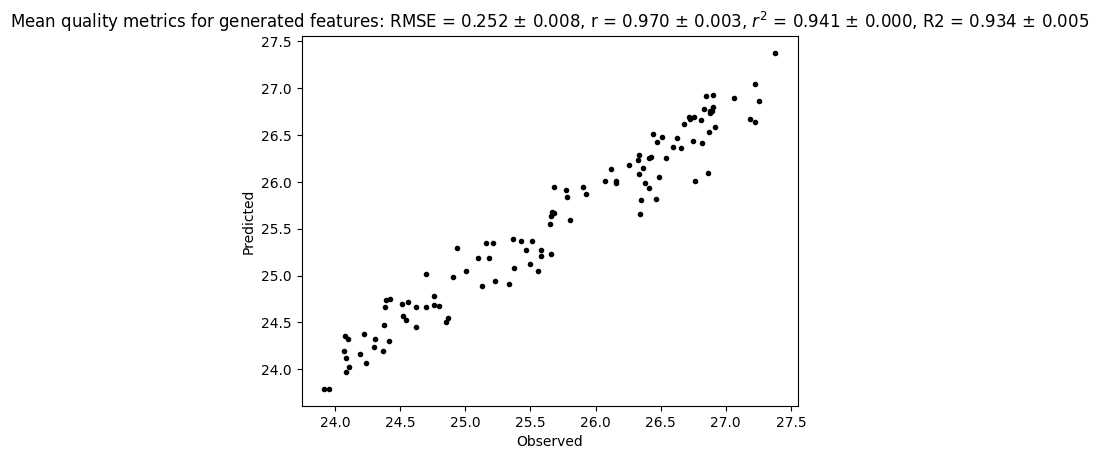

In [250]:
plt.figure()
plt.plot(last_y_test_gen, last_y_test_predicted_gen, '.k')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title(f'Mean quality metrics for generated features: RMSE = {np.mean(model_rmse):.3f} \u00B1 {np.std(model_rmse):.3f}, ' 
          f'r = {np.mean(model_r):.3f} \u00B1 {np.std(model_r):.3f}, ' 
          f'$r^2$ = {(np.mean(model_r)**2):.3f} \u00B1 {(np.std(model_r)**2):.3f}, ' 
          f'R2 = {np.mean(model_R2):.3f} \u00B1 {np.std(model_R2):.3f}')

Представленный выше график подтверждает вывод об уменьшении СКО, увеличении ее неопределенности, а также росте коэффициентов корреляции и детерминации и их неопределенности (*стандартное отклонение коэффициента корреляции и его квадрата не меняются по сравнению с исходными*). Итак, модель вполне **надежно** позволяет воспроизводить значения ТПО по таким предикторам, как температура воздуха на 2, ДУМ, АО, аномалия Т2, индекс ДУМ и градиент АО. Но тут надо сделать **<u>примечание</u>**, что наши новые признаки сделаны путем *нехитрых* преобразований старых, поэтому вполне естественно, что наблюдается **рост достоверности** и **уменьшение ошибок** при **увеличении неопределенности**.

In [251]:
print('Model θ with generated features')
for i in range(model_theta.shape[1]):
    mean_val = np.mean(model_theta[:, i])
    std_val = np.std(model_theta[:, i])
    display(Math(fr'\theta_{{{i}}} = {mean_val:.3f} \pm {std_val:.3f}'))

Model θ with generated features


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

*I коэффициент - **Т2**, II - **ДУМ**, III - **АО**, IV - аномалия **Т2**, V - **индекс ДУМ**, VI - **градиент АО***

 Как можно было ожидать, сумма средних значений I и IV коэффициентов (связаны **Т2**) примерно равна исходному значению коэффициента $\theta$ для температуры. Аналогичная ситуация наблюдается и для ее неопределенности (с точностью до сотых). Для ДУМ и его индекса сумма средних значений $\theta$ (II и V коэффициенты) меньше, чем для исходного ДУМ, а сумма их $\sigma$ - больше. Для АО и их градиента (III и VI коэффициенты $\theta$) наблюдается интересная ситуация: среднее значение коэффициента $\theta$ для АО положительно (как для исходного признака), а его градиента - отрицательно (*следует из определения градиента*). Их сумма не равна исходному коэффициенту для АО, но сумма их $\sigma$ - равна исходному стандартному отклонению. Итак, **наибольшая неопределенность** прослеживаается для ДУМ и его индекса (**максимальная $\sigma$**), тогда как для исходных признаков эта величина была максимальная для Т2. **Наименьшая**, как и в случае первоначального массива признаков, - для атмосферных осадков. Наиболее велико среднее значение коэффициента $\theta$ для Т2 и ее аномалии, *что согласуется с начальной ситуацией*.

## **Пункт 3**. Применяем стандартный метод **ShuffleSplit**.

In [229]:
n_splits = 5
test_size = 0.2

rs = ShuffleSplit(n_splits=n_splits, test_size=test_size)

model_theta = [] # коэффициенты модели тета
model_rmse = [] # метрика качества - СКО
model_r = [] # метрика качества - коэффициент корреляции
model_R2 = [] # метрика качества - коэффициент детерминации

for train_index, test_index in tqdm(rs.split(X_array), total=n_splits):
    X_train, X_test = X_array[train_index], X_array[test_index]
    y_train, y_test = y_array[train_index], y_array[test_index]
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_test_predicted = model.predict(X_test)

    y_test_flat = y_test.flatten()
    y_test_predicted_flat = y_test_predicted.flatten()
    
    model_theta.append(np.copy(model.coef_))
    model_rmse.append(np.sqrt(mean_squared_error(y_test_flat, y_test_predicted_flat)))
    model_r.append(np.corrcoef(y_test_flat, y_test_predicted_flat)[0, 1])
    model_R2.append(r2_score(y_test_flat, y_test_predicted_flat))

model_theta = np.array(model_theta).squeeze()
model_rmse = np.array(model_rmse).squeeze()
model_r = np.array(model_r).squeeze()
model_R2 = np.array(model_R2).squeeze()

100%|██████████| 5/5 [00:00<00:00, 25.43it/s]


Text(0.5, 1.0, 'Mean quality metrics: RMSE = 0.256 ± 0.015, r = 0.966 ± 0.005, $r^2$ = 0.934 ± 0.000, R2 = 0.933 ± 0.009')

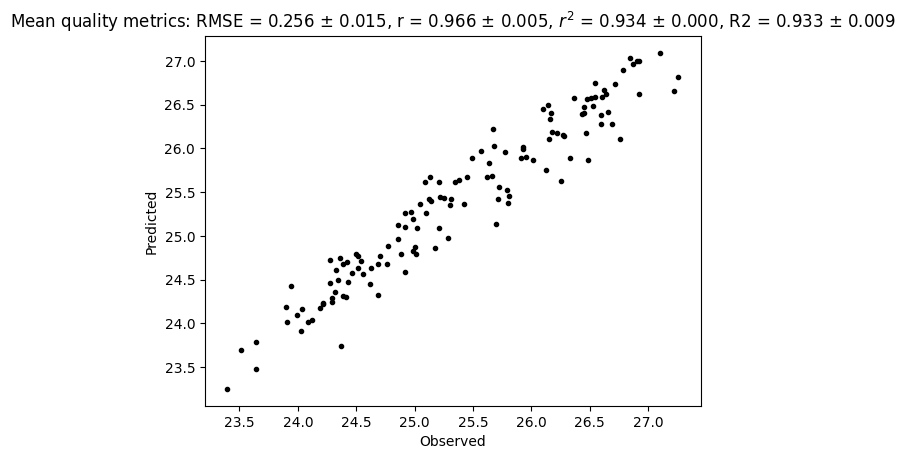

In [230]:
plt.figure()
plt.plot(y_test, y_test_predicted, '.k')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title(f'Mean quality metrics: RMSE = {np.mean(model_rmse):.3f} \u00B1 {np.std(model_rmse):.3f}, '
          f'r = {np.mean(model_r):.3f} \u00B1 {np.std(model_r):.3f}, '
          f'$r^2$ = {(np.mean(model_r)**2):.3f} \u00B1 {(np.std(model_r)**2):.3f}, '
          f'R2 = {np.mean(model_R2):.3f} \u00B1 {np.std(model_R2):.3f}')

Полученный график дает основание утверждать, что метод **ShuffleSplit** *достаточно уверенно* позволяет моделировать ТПО. Высокие значения средних коэффициентов корреляции (**значительная** линейная связь между "реальной" и "спрогнозированной" ТПО) и детерминации (модель воспроизводит **основную изменчивость** ТПО), малая средняя СКО (**большая точность** модели). Неопределенность данных метрик качества, определяемая стандартным отклонением $\sigma$, также вполне невелика. Ее величина максимальна для **СКО** и с точностью до тысячных равна 0 для **квадрата коэффициента корреляции**, как и для методов **TimeSeriesSplit** и **Bootstrap**. Сравнивая вычисленные метрики качества и их неопределенность с основным методом **TimeSeriesSplit**, можно заметить, что все средние величины (*кроме СКО, квадрата коэффициента корреляции и коэффициента детерминации*) совпадают, тогда как стандартное отклоненение более заметно (для СКО - на 1 порядок) отличается. Наибольшая разница в средних значениях - для СКО (на 0.009). Для нее же отмечается и максимальная разница в дисперсии - 0.011. В то время как среднее значение СКО для метода **ShuffleSplit** меньше, чем для **TimeSeriesSplit**, средние значения квадрата коэффициента корреляции и коэффициента детерминации в нем превышают аналогичные параметры для ранее использовавшегося **TimeSeriesSplit**. 

In [232]:
print('Model θ')
for i in range(model_theta.shape[1]):
    mean_val = np.mean(model_theta[:, i])
    std_val = np.std(model_theta[:, i])
    display(Math(fr'\theta_{{{i}}} = {mean_val:.3f} \pm {std_val:.3f}'))

Model θ


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

 Аналогично 2 раннее рассмотренным методам, для метода **ShuffleSplit** значение I коэффициента (**Т2**) <u>максимально</u>, стандартное отклонение относительно мало - оценка коэффициента **надежна**. II коэффициент (**ДУМ**) отрицателен, стандартное отклонение невелико (но *максимально* по сравнению с другими коэффициентами $\theta$) - как и для Т2, оценка данного коэффициента  **надежна**. III коэффициент (**АО**) положителен, как и I, но его значение очень невелико (**почти нет влияния**) и, как и в методе **TimeSeriesSplit**, всего лишь на 0.002 превышает собственное стандартное отклонение. Интересно отметить, что средние значения модельных коэффициентов $\theta$ (отличающиеся от полученных для **TimeSeriesSplit**) более близки к первоначальным коэффициентам самой модели - так I и II коэффициенты отличаются на 0.002 и 0.001 соответственно. Неопределенность для II коэффициента меньше, чем полученная в методе **Bootstrap** на 0.007

## **Пункт 5**. Реализуем **алгоритм генерации тренировочных и тестовых выборок** для выбранного метода кросс-валидации как класс с методом-генератором split, совместимый с функциями cross_val_score и cross_validate библиотеки scikit-learn.

*Поскольку это задание является "дополнительным" и "творческим", честно признаюсь, что я ориентировалась на пример Михаила Ивановича Варенцова из Jupyter Notebook 'Lect05c_CV_real_data', использовала интернет-ресурсы и собственную фантазию. Насколько я понимаю, "бонусность" задания позволяла проявить такую "свободу". Мне было интересно попробовать новое и поработать с теми объектами и модулями Python, с которыми работать еще не приходилось.*

In [269]:
import numpy as np
from sklearn.utils import indexable

class TimeSeriesSplitAlgoritm:
    def __init__(self, n_splits=5):
        self.n_splits = n_splits
        self.splits = None
    
    def split(self, X, y=None, groups=None):
        X, y = indexable(X, y)
        n_samples = len(X)
        
        # вычисляем размер каждого фолда
        fold_size = n_samples // (self.n_splits + 1)
        
        indices = np.arange(n_samples)
        
        for i in range(self.n_splits):
            # тренировочные индексы: от начала до текущего момента
            train_end = (i + 1) * fold_size
            train_indices = indices[:train_end]
            
            # тестовые индексы: следующий фолд после тренировочных
            test_start = train_end
            test_end = test_start + fold_size
            test_indices = indices[test_start:test_end]

            train_indices = np.array(train_indices)
            test_indices = np.array(test_indices)
            
            yield train_indices, test_indices
    
    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

if __name__ == "__main__":

    # применим к нашим исходным данным, чтобы удостовериться, что всё работает правильно   

    X = X_array
    y = y_array

    tscv = TimeSeriesSplitAlgoritm(n_splits=5)
    
    print('Time series split')
    for fold, (train_indices, test_indices) in enumerate(tscv.split(X, y)):
        print(f'Fold: {fold + 1}:')
        print(f'Training: {train_indices}')
        print(f'Test: {test_indices}')

Time series split
Fold: 1:
Training: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109]
Test: [110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219]
Fold: 2:
Training: [  0   1   2   3   4   5   6   7   8   9  

In [270]:
    model = LinearRegression()

    print('Сross_val_score results')
    r2_scores = cross_val_score(model, X, y.ravel(), cv=tscv, scoring='r2')
    rmse_scores = cross_val_score(model, X, y.ravel(), cv=tscv, scoring='neg_root_mean_squared_error')

    print ('RMSE cross_val_score mean: ', -rmse_scores.mean()) 
    print ('RMSE cross_val_score std: ', rmse_scores.std()) 

    print ('R2 cross_val_score mean: ', r2_scores.mean()) 
    print ('R2 cross_val_score std: ', r2_scores.std()) 

    print('Cross_validate results')

    scoring = ['r2', 'neg_root_mean_squared_error']

    results = cross_validate(model, X, y.ravel(), cv=tscv, scoring=scoring, return_train_score=True, return_estimator=True)

    print('RMSE cross_validate mean (train): ', -results['train_neg_root_mean_squared_error'].mean()) 
    print('RMSE cross_validate std (train): ', results['train_neg_root_mean_squared_error'].std()) 
    print('RMSE cross_validate mean (test): ', -results['test_neg_root_mean_squared_error'].mean()) 
    print('RMSE cross_validate std (test): ', results['test_neg_root_mean_squared_error'].std()) 

    print('R2 cross_validate mean (train): ', results['train_r2'].mean())
    print('R2 cross_validate std (train): ', results['train_r2'].std()) 
    print('R2 cross_validate mean (test): ', results['test_r2'].mean())
    print('R2 cross_validate std (test): ', results['test_r2'].std()) 

Сross_val_score results
RMSE cross_val_score mean:  0.26466468018387124
RMSE cross_val_score std:  0.004199448624148393
R2 cross_val_score mean:  0.9277950876669087
R2 cross_val_score std:  0.004464303482057007
Cross_validate results
RMSE cross_validate mean (train):  0.25483816565885015
RMSE cross_validate std (train):  0.001383087856149059
RMSE cross_validate mean (test):  0.26466468018387124
RMSE cross_validate std (test):  0.004199448624148393
R2 cross_validate mean (train):  0.931853714070552
R2 cross_validate std (train):  0.0011283392649815015
R2 cross_validate mean (test):  0.9277950876669087
R2 cross_validate std (test):  0.004464303482057007


Видно, что полученные с помощью 2 подходов кросс-валидации (**Сross_val_score** и **Cross_validate**) для алгоритма **TimeSeriesSplitAlgoritm** средние значения и неопределенность (*стандартное отклонение*) СКО и коэффициента детерминации для всей выборки, а также отдельно для тренировочной и тестовой выборок **<u>полностью совпадают</u>** с аналогичными параметрами для исходно примененного метода **TimeSeriesSplit**.

In [272]:
model_theta = [] # коэффициенты модели тета
model_rmse = [] # метрика качества - СКО
model_r = [] # метрика качества - коэффициент корреляции
model_R2 = [] # метрика качества - коэффициент детерминации

# сохраняем последние тестовые данные для графика
last_y_test = None
last_y_test_predicted = None

for train_indices, test_indices in tqdm(tscv.split(X, y), total=5):
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_test_predicted = model.predict(X_test)

    y_test_flat = y_test.flatten()
    y_test_predicted_flat = y_test_predicted.flatten()
    
    model_theta.append(np.copy(model.coef_))
    model_rmse.append(np.sqrt(mean_squared_error(y_test_flat, y_test_predicted_flat)))
    model_r.append(np.corrcoef(y_test_flat, y_test_predicted_flat)[0, 1])
    model_R2.append(r2_score(y_test_flat, y_test_predicted_flat))
    
    # сохраняем последний фолд для графика
    last_y_test = y_test
    last_y_test_predicted = y_test_predicted

model_theta = np.array(model_theta).squeeze()
model_rmse = np.array(model_rmse).squeeze()
model_r = np.array(model_r).squeeze()
model_R2 = np.array(model_R2).squeeze()

100%|██████████| 5/5 [00:00<00:00, 294.03it/s]


Text(0.5, 1.0, 'Mean quality metrics for last test fold: RMSE = 0.265 ± 0.004, r = 0.966 ± 0.003, $r^2$ = 0.933 ± 0.000, R2 = 0.928 ± 0.004')

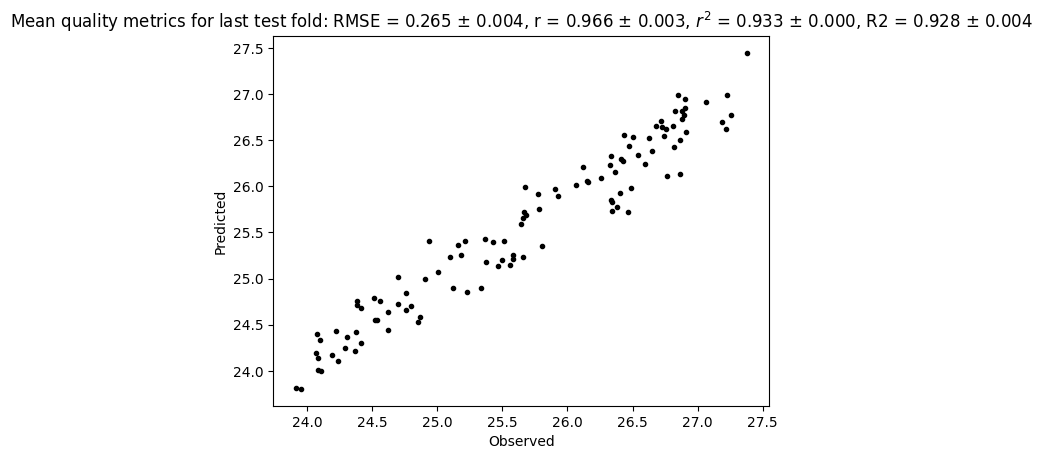

In [273]:
plt.figure()
plt.plot(last_y_test, last_y_test_predicted, '.k')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title(f'Mean quality metrics for last test fold: RMSE = {np.mean(model_rmse):.3f} \u00B1 {np.std(model_rmse):.3f}, ' 
          f'r = {np.mean(model_r):.3f} \u00B1 {np.std(model_r):.3f}, ' 
          f'$r^2$ = {(np.mean(model_r)**2):.3f} \u00B1 {(np.std(model_r)**2):.3f}, ' 
          f'R2 = {np.mean(model_R2):.3f} \u00B1 {np.std(model_R2):.3f}')

Полученный график также подтверждает, что алгоритм **TimeSeriesSplitAlgoritm** работает "правильно" - рассчитанные значения **средних коэффициентов корреляции** и **детерминации**, **средняя СКО** и **неопределенность** вышеописанных метрик качества (*стандартное отклонение $\sigma$*) **<u>полностью совпадают</u>** со сходными характеристиками для изначально использованного метода **TimeSeriesSplit**.

In [275]:
print('Model θ')
for i in range(model_theta.shape[1]):
    mean_val = np.mean(model_theta[:, i])
    std_val = np.std(model_theta[:, i])
    display(Math(fr'\theta_{{{i}}} = {mean_val:.3f} \pm {std_val:.3f}'))

Model θ


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Наконец, **средние значения** и **неопределенность** I, II и III коэффициентов модели (**Т2**, **ДУМ** и **АО** соответственно) также полностью согласуются с полученными величинами для ранее реализованного метода **TimeSeriesSplit**. На основании всего вышеперечисленного можем сделать вывод, что наш алгоритм работает **<u>правильно</u>**.

Видно, что полученные с помощью 2 подходов кросс-валидации (**Сross_val_score** и **Cross_validate**) для алгоритма **TimeSeriesSplitAlgoritm** средние значения и неопределенность (*стандартное отклонение*) СКО и коэффициента детерминации для всей выборки, а также отдельно для тренировочной и тестовой выборок **<u>полностью совпадают</u>** с аналогичными параметрами для исходно примененного . На основании этого можем сделать вывод, что наш алгоритм работает **<u>правильно</u>**.

*Ура!*